# Import packages

In [128]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
import pandas as pd
import re
import warnings
from patsy import dmatrices
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers, optimizers
import os
from keras import backend as K
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import collections

In [129]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler 

In [130]:
#custom functions
def groupmeans(G, X):
    gm = pd.concat([G, X], axis = 1).groupby(G.columns[0], axis = 0).mean()
    print(gm.isna().sum())
    GM = np.empty(shape = X.shape)
    for j in np.unique(G.values):
        idx = np.where(j == G.values)[0]
        toput = np.repeat(gm.loc[j,].values.reshape(1,GM.shape[1]), repeats = len(idx), axis = 0)
        GM[idx,:] = toput
    return GM

# ols function
def ols(X, y, lam = 0, parapen = None):
    # default value is unpenalized
    if parapen is None:
        parapen = np.zeros(X.shape[1])
    # sanity check
    assert (len(parapen) == X.shape[1]), "wrong length for parapen"
    penmat = np.diag(parapen*lam) 
    b = np.dot(np.linalg.inv(np.dot(X.T, X)+ penmat), np.dot(X.T, y))
    return(b)

# function to get FE estimates
def getfe(b, GMx, GMy):
    fe = GMy - np.dot(GMx, b)
    return fe

# mse function
def mse(x, y):
    return ((x-y)**2).mean()

# function to build a SNN for a fixed effects model
def SNN_constructor(P, NP, FE, lam, nlayers = 10, nnodes = None, drate = 0,
                    NP_out_dim = 1, use_BN = True, LR = .001):
    # default to 25 nodes per layer if not specified
    if nnodes is None:
        nnodes = np.repeat(25, nlayers)
    if nnodes[-1] != NP_out_dim:
        nnodes[-1] = nnodes[-1]**0 * NP_out_dim
    # nonparametric part
    input_np = Input(shape = (NP.shape[1],), name = "nonparametric_input")
    # first layer
    lay = Dense(nnodes[0], activation = "relu", 
                kernel_regularizer=regularizers.l2(lam))(input_np)
    if use_BN == True:
        lay = BatchNormalization()(lay)
    # subsequent layers
    for i in range(1,nlayers):
        lay = Dropout(rate = drate)(lay)
        if i == max(range(nlayers)):
            layname = "np_top"
        else:
            layname = "layer_" + str(i)
        lay = Dense(nnodes[i], activation = "relu", name = layname,
                    kernel_regularizer=regularizers.l2(lam))(lay)
        if use_BN == True:
            lay = BatchNormalization()(lay)
    # parametric part
    input_p = Input(shape = (P.shape[1],), name = "parametric_input")
    # FE part
    input_fe = Input(shape = (FE.shape[1],), name = "FE_input")
    fe_lay = Dense(1, use_bias = False, name = "FE_output")(input_fe)
    # concatenate them
    conc = concatenate([fe_lay, input_p, lay], name = "conc")
    # output
    out = Dense(1, name = "top", use_bias = False,
                kernel_regularizer=regularizers.l2(lam))(conc)
    # compile
    model = Model(inputs = [input_fe, input_p, input_np], outputs = out)
    optimizer = tf.keras.optimizers.Nadam(learning_rate = LR)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# extraction of top layer function
def get_top_layer(model, trdat, 
                  conclayername = "conc", toplayername = "top"):
    # define model to extract from 
    extr = Model(inputs = model.input,
                 outputs = model.get_layer(conclayername).output)
    toplayer = extr.predict(trdat)
    return(toplayer)

# put weights back into keras model 
def replace_top_weights_fe(model, beta, alpha, toplayername = "top", felayername = "FE_output"):
    # beta
    old = model.get_layer(toplayername).get_weights()[0]
    for b in range(len(beta)):
        if b == 0: # set the FE layer to one
            old[b] =(old[b]**0).reshape(old[b].shape) 
        else:
            old[b] = (old[b]**0)*beta[b-1].reshape(old[b].shape)
    model.get_layer(toplayername).set_weights([old])
    # alpha
    old = model.get_layer(felayername).get_weights()[0]
    for a in range(len(alpha)):
        old[a] = (old[a]**0)*alpha.values[a].reshape(old[a].shape)
    model.get_layer(felayername).set_weights([old])

# olstrick wrapper function
def fe_olstrick(model, trdat, y, fe, lam, parapen,
                conclayername = "conc", toplayername = "top"):
    toplayer = get_top_layer(model, trdat, conclayername, toplayername)[:,1:] # remove FE row
    xbar = groupmeans(fe, pd.DataFrame(toplayer, index = fe.index))
    ybar = groupmeans(fe, y)
    newb = ols(X = toplayer - xbar, 
            y = np.array(y) - ybar,
            lam = lam, parapen = parapen)
    alpha = getfe(newb, xbar, ybar)
    #print(pd.DataFrame(alpha).isna().sum())
    #print(np.isnan(alpha).sum())
    alpha = pd.concat([fe, pd.DataFrame(alpha, index = fe.index)], axis = 1).groupby(by = "lat_lon").mean()
    #print(np.isnan(xbar).sum())
    #print(np.isnan(ybar).sum())
    #mprint(np.isnan(alpha).sum())
    replace_top_weights_fe(model, newb, alpha)

def fit_with_FE_olstrick(y, P, NP, FE, # input data
                         tr_idx, te_idx, # train and test indices
                         lam, drate, # tunable hyperparameters
                         batchsize, epochs, LR, # training parameter
                         nnodes, NP_out_dim, nlayers, # architecture
                         weight_location): # path to weights
    trdat = [FE[tr_idx,:],
             P[tr_idx,:],
             NP[tr_idx,:]]

    tedat = [FE[te_idx,:],
             P[te_idx,:],
             NP[te_idx,:]]
    print("starting constructor")
    model = SNN_constructor(P = P,
                        NP = NP,
                        FE = FE,
                        lam = lam,
                        nlayers = nlayers,
                        nnodes = np.repeat(nnodes, nlayers),
                        NP_out_dim = NP_out_dim,
                        drate= drate,
                        LR = LR)
    global bestweights
    if bestweights is not None:
        model.set_weights(bestweights)
    best_mse = mse(model.predict(tedat), y.loc[te_idx,:])
    callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                 ModelCheckpoint(filepath=weight_location+'temp_weights.h5', monitor='val_loss', save_best_only=True)]
    print("fitting model")
    model.fit(x = trdat, 
              y = y.loc[tr_idx,:],
              validation_data = (tedat, y.loc[te_idx,:]),
              callbacks = callbacks,
              batch_size  = batchsize,
              verbose = 0,
              epochs = epochs)
    print("loading weights")
    if "temp_weights.h5" in os.listdir(weight_location):
        model.load_weights(weight_location+"temp_weights.h5")    
    print("doing OLStrick")
    parapen = np.repeat(1, P.shape[1]+NP_out_dim) # we're not leaving some terms unpenalized here.  we could if we wanted.
    fe_olstrick(model, trdat, y.loc[tr_idx,:], fe.loc[tr_idx,:], lam, parapen)
    current_mse = mse(model.predict(tedat), y.loc[te_idx,:])
    improvement = best_mse - current_mse
    if current_mse.values < best_mse.values:
        bestweights = model.get_weights()
    # output
    out = pd.DataFrame(data = {"lam":lam,
                        "drate":drate,
                        "batchsize":batchsize,
                        "LR":LR,
                        "improvement":improvement.values[0]}, index = [0])
    return {"model": model, "out":out}


# Set paths and read-in data

In [131]:
#now mount to drive and set the working directory to our shared drive
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
train_data_path = '/content/drive/Shareddrives/Spatial_Term_Paper/data/model_runs/train_data/'
path = '/content/drive/Shareddrives/Spatial_Term_Paper/code/model_runs/'
os.chdir(train_data_path)
historical_df = pd.read_csv('historical_df.csv').drop('Unnamed: 0', axis = 1) #index_col = ['lat', 'lon', 'growing_season']
#path for predict data is '/content/drive/Shareddrives/Spatial_Term_Paper/data/model_runs/predict_data/'
#ssp126_df = pd.read_csv('ssp126_df.csv').drop('Unnamed: 0', axis = 1)
#ssp370_df = pd.read_csv('ssp370_df.csv').drop('Unnamed: 0', axis = 1)
#ssp585_df = pd.read_csv('ssp585_df.csv').drop('Unnamed: 0', axis = 1)

# Preprocessing

In [133]:
#we observe that there is only one maize growing season in Malawi - drop maize_second
historical_df = historical_df.drop('maize_second', axis = 1)
#also maize and maize major are the same so drop one
sum(historical_df['maize'] == historical_df['maize_major']) #sum is not length of ds because of nas, we will deal with this later
historical_df = historical_df.drop('maize_major', axis = 1)
#also we can drop the scenario columns
historical_df = historical_df.drop('scenario', axis=1)
#drop pr_min because it's a vector of 0's
historical_df = historical_df.drop('pr_min', axis = 1)

In [134]:
#make lat lon one column instead of two for fixed effects
historical_df['lat_lon'] = [str(x)+'_'+str(y) for x, y in historical_df[['lat', 'lon']].itertuples(index=False)]

In [135]:
#get index of values that are nas
na_index = historical_df[historical_df['maize'].isna()].index

In [136]:
##so we have 5 latitide/longitude points for which we have no crop_yield data - these are backfilled for now 
#historical_df = historical_df[historical_df['maize'].notna()] #can't drop because it messes up the time series
#print(historical_df.isna().sum())
#historical_df = historical_df.fillna(method = 'ffill')

In [137]:
#impute later
historical_df.loc[340:360, ['lat', 'lon', 'maize']]

,lat,lon,maize
340,-14.75,35.25,0.408137
341,-14.75,35.25,1.499109
342,-14.75,35.25,0.835762
343,-14.75,35.25,1.291826
344,-14.75,35.25,1.524369
345,-14.75,35.25,1.132099
346,-14.75,35.25,1.462958
347,-14.75,35.25,1.843597
348,-14.75,35.25,1.639267
349,-14.75,35.25,1.173321


In [138]:
#observe distribution of crop yield

In [139]:
#set target
target = 'maize'

#assign variables so we can manipulate easy 
precipitation = ['pr_percentile_25', 'pr_percentile_50','pr_percentile_75', 'pr_max']
sfc_air_temp_max = ['tasmax_min', 'tasmax_percentile_25', 'tasmax_percentile_50',
       'tasmax_percentile_75', 'tasmax_max']
sfc_air_temp_min = ['tasmin_min', 'tasmin_percentile_25',
       'tasmin_percentile_50', 'tasmin_percentile_75', 'tasmin_max']
sfc_air_temp_mean = ['tas_min', 'tas_percentile_25', 'tas_percentile_50',
       'tas_percentile_75', 'tas_max']
sfc_wind = ['sfcwind_min', 'sfcwind_percentile_25', 'sfcwind_percentile_50',
       'sfcwind_percentile_75', 'sfcwind_max']
relative_humidity = ['huss_min',
       'huss_percentile_25', 
       'huss_percentile_50', 
       'huss_percentile_75',
       'huss_max'] 
specific_humidity = ['huss_min',
       'huss_percentile_25', 
       'huss_percentile_50', 
       'huss_percentile_75',
       'huss_max']
longwave_radiation = ['rlds_min',
       'rlds_percentile_25', 'rlds_percentile_50', 'rlds_percentile_75',
       'rlds_max']
shortwave_radiation = ['rsds_min', 'rsds_percentile_25', 'rsds_percentile_50',
       'rsds_percentile_75', 'rsds_max']
air_pressure = ['ps_min', 'ps_percentile_25', 'ps_percentile_50', 'ps_percentile_75', 'ps_max']
gdd = ['tas_gdd']
lat = ['lat']
lon = ['lon']
growing_season = ['growing_season']
#make time squared variable
historical_df['growing_season_squared'] = historical_df['growing_season']**2
growing_season_squared = ['growing_season_squared']
historical_df.columns

Index(['lat', 'lon', 'growing_season', 'ps_min', 'ps_percentile_25',
       'ps_percentile_50', 'ps_percentile_75', 'ps_max', 'pr_percentile_25',
       'pr_percentile_50', 'pr_percentile_75', 'pr_max', 'huss_min',
       'huss_percentile_25', 'huss_percentile_50', 'huss_percentile_75',
       'huss_max', 'hurs_min', 'hurs_percentile_25', 'hurs_percentile_50',
       'hurs_percentile_75', 'hurs_max', 'tas_min', 'tas_percentile_25',
       'tas_percentile_50', 'tas_percentile_75', 'tas_max', 'tas_gdd',
       'sfcwind_min', 'sfcwind_percentile_25', 'sfcwind_percentile_50',
       'sfcwind_percentile_75', 'sfcwind_max', 'rlds_min',
       'rlds_percentile_25', 'rlds_percentile_50', 'rlds_percentile_75',
       'rlds_max', 'rsds_min', 'rsds_percentile_25', 'rsds_percentile_50',
       'rsds_percentile_75', 'rsds_max', 'tasmin_min', 'tasmin_percentile_25',
       'tasmin_percentile_50', 'tasmin_percentile_75', 'tasmin_max',
       'tasmax_min', 'tasmax_percentile_25', 'tasmax_percentile_50

# Climate predictions

In [140]:
#read in climate data
predict_path = '/content/drive/Shareddrives/Spatial_Term_Paper/data/model_runs/predict_data'
os.chdir(predict_path)
ssp126 = pd.read_csv('ssp126_df.csv').drop(['Unnamed: 0', 'scenario'], axis = 1)
ssp370 = pd.read_csv('ssp370_df.csv').drop(['Unnamed: 0', 'scenario'], axis = 1)
ssp585 = pd.read_csv('ssp585_df.csv').drop(['Unnamed: 0', 'scenario'], axis = 1)

In [141]:
#na values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 100, missing_values=np.nan, weights = 'distance', add_indicator = False)
features = list(ssp126.columns)
ssp126 = imputer.fit_transform(ssp126)
ssp126 = pd.DataFrame(ssp126, columns = features)

In [142]:
scenarios = [ssp126, ssp370, ssp585]
scenario_names = ['ssp126', 'ssp370', 'ssp585']

In [143]:
#make growing season
for scenario in scenarios:
  scenario['growing_season_squared'] = scenario['growing_season']**2


In [144]:
#drop pr_min
for scenario in list(range(0, len(scenarios))):
  scenarios[scenario] = scenarios[scenario].drop('pr_min', axis = 1)

## RF

In [148]:
#set params
param_grid={'ccp_alpha':0, 'max_depth':7,
                                       'min_samples_leaf':5, 'n_estimators':150,
                                       'oob_score':True, 'random_state':123}
best_RF_model = RandomForestRegressor()
best_RF_model.set_params(**param_grid)

RandomForestRegressor(ccp_alpha=0, max_depth=7, min_samples_leaf=5,
                      n_estimators=150, oob_score=True, random_state=123)

In [149]:
#fit to produce predictions
historical_df = historical_df.drop('lat_lon', axis = 1)
imputer = KNNImputer(n_neighbors = 100, missing_values=np.nan, weights = 'distance', add_indicator = False)
features = list(historical_df.columns)
historical_df = imputer.fit_transform(historical_df)
historical_df = pd.DataFrame(historical_df, columns = features)
target = historical_df['maize']
historical_df = historical_df.drop('maize', axis = 1)
features = list(historical_df.columns)
scaler = StandardScaler()
historical_df = scaler.fit_transform(historical_df)
historical_df = pd.DataFrame(historical_df, columns = features)

In [150]:
best_RF_model.fit(historical_df, target)

RandomForestRegressor(ccp_alpha=0, max_depth=7, min_samples_leaf=5,
                      n_estimators=150, oob_score=True, random_state=123)

In [176]:
best_RF_model.oob_score_

0.6994342357805179

In [155]:
count = 0
for scenario in scenarios:
  scaler = StandardScaler()
  scenario_train = scaler.fit_transform(scenario)
  scenario_train = pd.DataFrame(scenario_train, columns = list(scenario.columns))
  pred = best_RF_model.predict(scenario_train)
  results_path = '/content/drive/Shareddrives/Spatial_Term_Paper/results/'
  os.chdir(results_path)
  pred = pd.DataFrame(pred, index=scenario.index, columns = ['test_preds'])
  results = pd.concat([pred, scenario.loc[:, ['lat', 'lon']]], axis = 1)
  results['growing_season'] = scenario['growing_season']
  filename = scenario_names[count] + '_predicted.csv'
  results.to_csv(results_path + filename)
  count+=1


  

In [161]:
ssp126_preds = pd.read_csv('ssp126_predicted.csv').drop(['Unnamed: 0'], axis = 1)
ssp370_preds = pd.read_csv('ssp370_predicted.csv').drop(['Unnamed: 0'], axis = 1)
ssp585_preds = pd.read_csv('ssp585_predicted.csv').drop(['Unnamed: 0'], axis = 1)

In [163]:
ssp126_preds['scenario'] = 'ssp_126'
ssp370_preds['scenario'] = 'ssp_370'
ssp585_preds['scenario'] = 'ssp_585'

In [172]:
for_plot = pd.concat([ssp126_preds,ssp370_preds,ssp585_preds]).reset_index(drop=True)

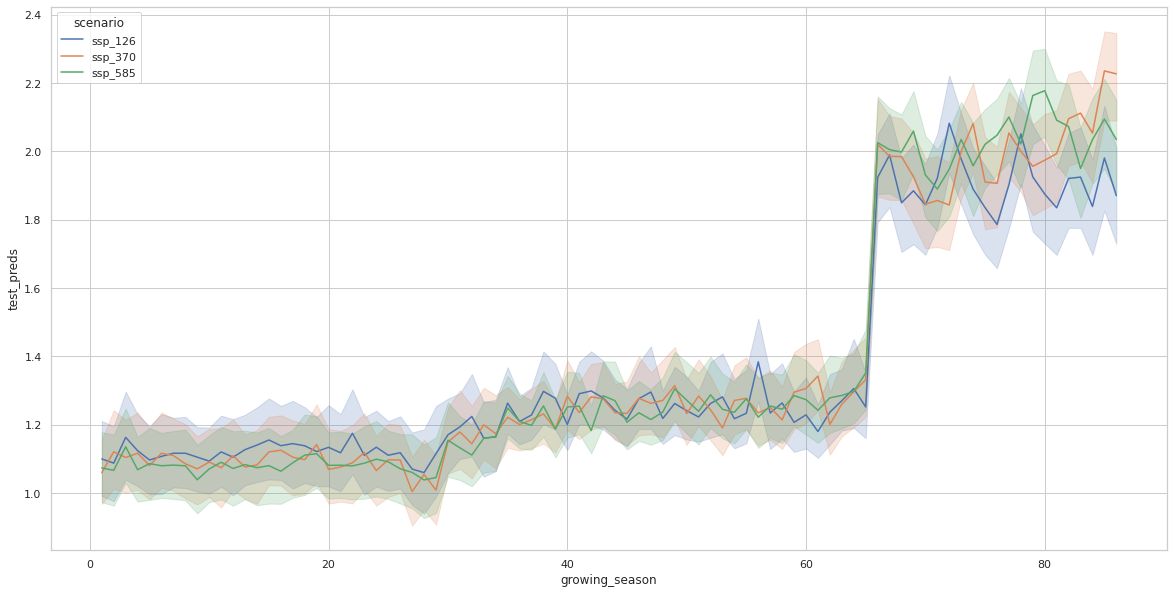

In [178]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")
sns.lineplot(data=for_plot, x="growing_season", y="test_preds", hue="scenario")